In [1]:
# Questi comandi permettono di usare in Jupyter le librerie di R presenti nel CRAN (Comprehensive R Archive Network)
country.code <- 'it'
url.pattern <- 'https://'  
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)

In [2]:
# Package utili: psych per le funzioni di stima dei parametri e readxl per poter leggere file excel
install.packages("readxl")
install.packages("ltm")

package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\Rtmp4mHWeR\downloaded_packages
package 'ltm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Marco\AppData\Local\Temp\Rtmp4mHWeR\downloaded_packages


In [3]:
# Importo i package
library("readxl")
library("ltm")

Warning message:
"package 'readxl' was built under R version 3.4.2"Warning message:
"package 'ltm' was built under R version 3.4.2"Loading required package: MASS
Loading required package: msm
Loading required package: polycor


In [4]:
#' Legge un file csv e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return data frame corrispondente al file csv indicato
#' @examples
#' readCSV("file.csv")
#'
#' readCSV("C:/Users/file.csv")
readCSV <- function(path) {
  read.csv(path, row.names = 1)
}

#' Legge un file excel e imposta la prima colonna con i nomi degli studenti come indici della tabella 
#'
#' @param path Percorso del file
#' @return data frame corrispondente al file excel indicato
#' @examples
#' readEXCEl("file.xlsx")
#'
#' readEXCEl("C:/Users/file.xlsx")
readEXCEl <- function(path) {
    items <- read_excel(path)
    items <- as.data.frame(items)
    rownames(items) <- items[,1]
    items <- items[,-1]
    items
}

In [5]:
# Importo la tabella dicotomica
datiDichot <- readEXCEl("EsameDic.xlsx")
datiDichot

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,0,0,0,0,0,0,0,0,0,0
S2,1,1,1,1,1,1,1,1,1,1
S3,1,1,1,1,0,1,1,1,1,0
S4,1,1,1,1,1,1,1,1,1,0
S5,1,0,1,1,1,1,1,0,0,1
S6,0,1,1,1,1,0,0,1,1,0
S7,1,1,0,0,1,1,1,0,0,0
S8,1,1,1,1,0,1,1,1,1,1
S9,1,1,1,1,1,0,1,1,1,0
S10,0,0,1,1,1,0,0,1,0,1


In [56]:
#' Modifica la dimensione dei grafici
#'
#' @param width Larghezza dei grafici
#' @param height Altezza dei grafici
#' @examples
#' width <- 7
#' height <- 5
#' sizePlot(width, height)
sizePlot <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

#' Rimpiazza i valori NA presenti nella tabella passata con 0
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Tabella dicotomica avente una riga per studente e una colonna per esercizio a cui sono stati sostituiti i NA con 0
#' @examples
#' items <- readEXCEl("file.xlsx")
#' replaceNaWithZero(items)
replaceNaWithZero <- function(items) {
    aux <- items
    aux[is.na(aux)] <- 0
    aux
}

#' Stima le difficoltà degli esercizi senza porre vincoli sul valore del discriminante
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param forNA Definisce il comportamento in caso di NA, di default è NULL quindi vengono ignorati, se si usasse 
#' forNA = na.exclude la stima verrebbe effettuata eliminando le righe in cui è presente almeno un NA
#' @return Vettore di difficoltà stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateDifficultiesDichotFreeDiscrim(items)
estimateDifficultiesDichotFreeDiscrim <- function(items, forNA = NULL) {
    param <- rasch(items, na.action = forNA)
    tab <- coef(param)
    array(tab[,"Dffclt"])
}

#' Stima le difficoltà degli esercizi ponendo il discriminante ad 1
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param forNA Definisce il comportamento in caso di NA, di default è NULL quindi vengono ignorati, se si usasse 
#' forNA = na.exclude la stima verrebbe effettuata eliminando le righe in cui è presente almeno un NA
#' @return Vettore di difficoltà stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateDifficultiesDichotOneDiscrim(items)
estimateDifficultiesDichotOneDiscrim <- function(items,  forNA = NULL) {
    param <- rasch(items, constraint = cbind(length(items) + 1, 1), na.action = forNA)
    tab <- coef(param)
    array(tab[,"Dffclt"])
}

#' Genera un grafico per mostrare il livello di difficoltà di ciascun esercizio 
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param diff Vettore di difficoltà
#' @param color Colore del grafico, di default è rosso
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotOneDiscrim(items)
#' plotDifficultiesDichot(items, diff)
plotDifficultiesDichot <- function(items, diff, color = "red") {
    nItems <- length(diff)
    plot(diff,xlim=c(1,nItems),ylim=c(-5,5),type="b",main="Difficulties plot",xlab="Items",ylab="Difficulty",xaxt="n",col=color,pch=16,lwd=2)
    axis(1, at=1:nItems, labels=names(items))
    par(new = TRUE)
    plot(diff + 4.7, type = "h", xlim = c(1,nItems),ylim = c(0,10), xaxt='n', yaxt = "n", xlab = "", ylab = "", lty = 2)
}

#' Stima le abilità degli studenti
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @return Vettore di abilità stimate
#' @examples
#' items <- readEXCEl("file.xlsx")
#' estimateAbilitiesDichot(items)
estimateAbilitiesDichot <- function(items) {
    fit <- rasch(items)
    fs <- factor.scores(fit, resp.patterns = items)
    array(unlist(fs$score.dat["z1"]))
}

#' Genera un istogramma per mostrare il livello di abilità degli studenti e la relativa quantità
#'
#' @param theta Vettore di abilità
#' @examples
#' items <- readEXCEl("file.xlsx")
#' abil <- estimateAbilitiesDichot(items)
#' plotDifficultiesDichot(abil)
plotAbilitiesDichot <- function(abil) {
    start <- -3
    end <- 
    by <- 0.5
    hist(abil,main="Ability histogram",xlab="Ability",ylab="Students",breaks=seq(start,end,by),xlim=c(start,end),col="royalblue3")
    axis(1, at=seq(start, end, by=0.5), labels=seq(start, end, by))        
}

In [110]:
#' Attraverso la tecnica di bootstrapping seleziona randomicamente n righe dalla matrice dicotomica, questa funzione è utlile 
#' se si dispone di pochi soggetti perchè in caso di una scarsa quantità di osservazioni lo stimatore potrebbe non covergere
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param n Numero di estrazioni
#' @return Data frame di difficoltà stimate dalla tabella generata dalle estrazioni casuali
#' @examples
#' items <- readEXCEl("file.xlsx")
#' bootstrapping(items)
bootstrapping <- function(items, n = 500) {
    idxs <- sample(1:nrow(items), n, replace = TRUE)
    items[idxs,]
}

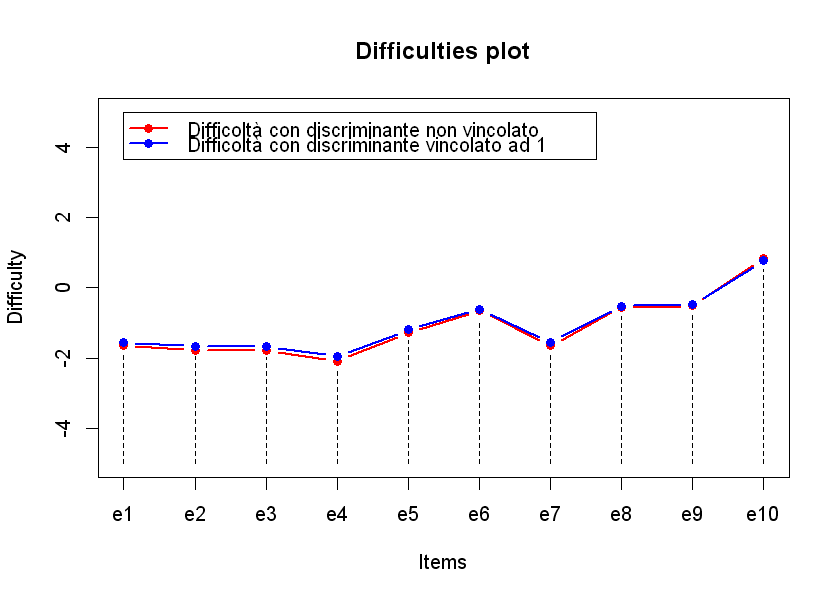

In [8]:
# Modifico la dimensione dei grafici
width <- 7
height <- 5
sizePlot(width, height)

# Effettuo il bootstrapping
numExtractions <- 700
bottDatiDichot <- bootstrapping(datiDichot, numExtractions)

# Stimo le difficoltà con entrambi i metodi
difficDichotF <- estimateDifficultiesDichotFreeDiscrim(bottDatiDichot)
difficDichotO <- estimateDifficultiesDichotOneDiscrim(bottDatiDichot)

# Visualizzo e confronto i grafici relativi alle difficoltà stimate con entrambi i metodi
plotDifficultiesDichot(datiDichot, difficDichotF)
par(new = TRUE)
plotDifficultiesDichot(datiDichot, difficDichotO, color = "blue")
legend(1, 10, legend=c("Difficoltà con discriminante non vincolato", "Difficoltà con discriminante vincolato ad 1"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)

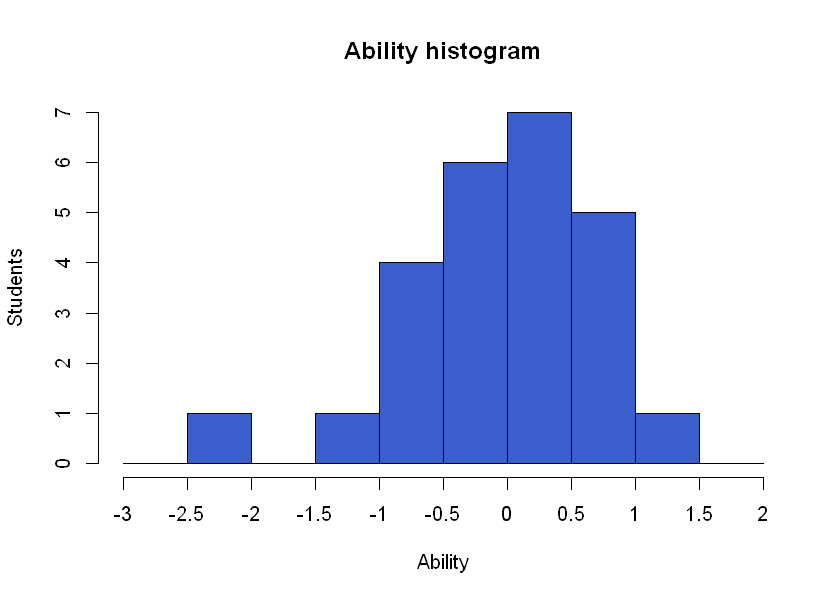

In [58]:
# Stimo le abilità e visualizzo il relativo grafico
abil <- estimateAbilitiesDichot(datiDichot)
plotAbilitiesDichot(abil)

In [10]:
#' Calcola la probabilità che uno studente risolva correttamente un esercizio
#'
#' @param ability Abilità dello studente
#' @param difficulty Difficoltà dell'esercizio
#' @return Probabilità di rispondere correttamente, compresa tra 0 e 1
#' @examples
#' ability <- 2
#' difficulty <- 1
#' pl1(ability, difficulty)
pl1 <- function(ability, difficulty) {
    exp(ability - difficulty) / (1 + exp(ability - difficulty))
}

#' Determina la probabilità per ogni studente di risolvere correttamente ogni esercizio
#'
#' @param items Tabella dicotomica avente una riga per studente e una colonna per esercizio
#' @param diff Vettore di difficoltà
#' @param abil Vettore di abilità
#' @return Data frame di probabilità
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotFreeDiscrim(items)
#' abil <- estimateAbilitiesDichot(items)
#' calcProbabilites(items, diff, abil)
calcProbabilites <- function(items, diff, abil) {   
    probDf <- items
    namesCol <- names(probDf)
    namesRow <- row.names(probDf)
    j <- 1
    for (row in namesRow) {
        i <- 1
        for (col in namesCol) {
            prob <- pl1(abil[j],diff[i])
            probDf[row,col] <- prob          
            i <- i + 1
        }
        j <- j + 1
    }
    probDf
}


#' Migliora la lettura della tabella delle probabilità per l'utente
#'
#' @param df Data frame di probabilità, output della funzione calcProbabilites
#' @return Data frame di probabilità da 0 a 100
#' @examples
#' items <- readEXCEl("file.xlsx")
#' diff <- estimateDifficultiesDichotFreeDiscrim(items)
#' abil <- estimateAbilitiesDichot(items)
#' dfProb <- calcProbabilites(items, diff, abil)
#' showProbabilities(dfProb)
showProbabilities <- function(df){
    aux <- trunc(df*100)
    aux <- data.frame(lapply(aux, function(p) paste(p, "%")))
    row.names(aux) <- row.names(df)
    aux
}

In [11]:
# Calcolo la tabella di probabilità che ogni studente risponda correttamente ad ogni test usando il discriminante non vincolato
dfP <- calcProbabilites(datiDichot, difficDichotF, abil)

# Visualizzo la tabella più semplicemente
showProbabilities(dfP)

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,32 %,35 %,35 %,42 %,24 %,14 %,32 %,13 %,13 %,3 %
S2,94 %,95 %,95 %,96 %,92 %,86 %,94 %,85 %,84 %,59 %
S3,87 %,88 %,88 %,91 %,82 %,71 %,87 %,70 %,69 %,37 %
S4,91 %,92 %,92 %,94 %,87 %,79 %,91 %,77 %,77 %,47 %
S5,82 %,84 %,84 %,88 %,76 %,63 %,82 %,61 %,60 %,28 %
S6,77 %,79 %,79 %,84 %,70 %,55 %,77 %,53 %,52 %,22 %
S7,71 %,73 %,73 %,79 %,62 %,47 %,71 %,45 %,44 %,17 %
S8,91 %,92 %,92 %,94 %,87 %,79 %,91 %,77 %,77 %,47 %
S9,87 %,88 %,88 %,91 %,82 %,71 %,87 %,70 %,69 %,37 %
S10,71 %,73 %,73 %,79 %,62 %,47 %,71 %,45 %,44 %,17 %


In [12]:
# Calcolo la tabella di probabilità che ogni studente risponda correttamente ad ogni test usando il discriminante vincolato ad 1
dfP <- calcProbabilites(datiDichot, difficDichotO, abil)

# Visualizzo la tabella più semplicemente
showProbabilities(dfP)

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
S1,30 %,32 %,33 %,39 %,23 %,14 %,30 %,13 %,13 %,4 %
S2,93 %,94 %,94 %,95 %,91 %,85 %,93 %,84 %,84 %,60 %
S3,86 %,87 %,87 %,90 %,81 %,71 %,86 %,69 %,68 %,38 %
S4,90 %,91 %,91 %,93 %,87 %,78 %,90 %,77 %,76 %,48 %
S5,81 %,83 %,83 %,86 %,75 %,62 %,81 %,60 %,60 %,29 %
S6,75 %,77 %,77 %,82 %,68 %,54 %,75 %,52 %,51 %,23 %
S7,69 %,71 %,71 %,77 %,61 %,46 %,69 %,44 %,43 %,17 %
S8,90 %,91 %,91 %,93 %,87 %,78 %,90 %,77 %,76 %,48 %
S9,86 %,87 %,87 %,90 %,81 %,71 %,86 %,69 %,68 %,38 %
S10,69 %,71 %,71 %,77 %,61 %,46 %,69 %,44 %,43 %,17 %


In [114]:
#' Genera una tabella dicotomica
#'
#' @param diff vettore di difficoltà scelte
#' @param abil vettore di abilità scelte
#' @return La tabella dicotomica generata
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' generateDichot(diffInit, abil)
generateDichot <- function(diff, abil) {
    items <- data.frame(matrix(0, ncol = length(diff), nrow = length(abil)))
    prob <- calcProbabilites(items, diff, abil)

    namesCol  <- names(items)
    namesRow  <- row.names(items)
    for (row in namesRow) {
        for (col in namesCol) {
            items[row,col] <- rbinom(1, 1, prob[row,col])         
        }
    }
    
    items
}

#' Valuta la bontà del mio stimatore misurando lo scostamento tra le difficoltà o le abilità passate per argomento
#'
#' @param vect1 vettore di difficoltà o abilità
#' @param vect2 vettore di difficoltà o abilità
#' @return Data frame con le difficoltà o abilità passate per argomento e lo scostamento rilevato
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diffInit, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithDifference(diffInit, diffEstim)
validationWithDifference <- function(vect1, vect2) { 
    scost <- abs(unlist(lapply(vect1 - vect2 , round, 2)))
    compare <- data.frame(vect1, vect2, scost)   
    colnames(compare) <- c("Vettore 1","Vettore 2", "Scostamento")
    compare
}

#' Valuta la bontà del mio stimatore confrontando graficamente le difficoltà o le abilità passate per argomento
#'
#' @param vect1 vettore di difficoltà o abilità
#' @param vect2 vettore di difficoltà o abilità
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diff, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithPlot(diffInit, diffEstim)
validationWithPlot <- function(vect1, vect2) {
    plot(vect1,xlim=c(1,length(vect1)),ylim=c(-4,4),type="b",main="Comparison plot",xlab="Observations",ylab="Values",xaxt="n",col="red",pch=16,lwd=2)
    axis(1, at = 1:length(vect1), labels = 1:length(vect1))
    par(new = TRUE)
    plot(vect2, type = "b", xlim = c(1,length(vect2)),ylim = c(-4,4), xaxt='n', yaxt = "n", xlab = "", ylab = "", col = "blue", pch=16, lwd=2)
    legend(1, 3, legend=c("Vettore 1", "Vettore 2"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)
    NULL
}

#' Valuta la bontà del mio stimatore calcolando il coefficiente di correlazione lineare
#'
#' @param vect1 vettore di difficoltà o abilità
#' @param vect2 vettore di difficoltà o abilità
#' @return Valore numerico compreso tra -1 e 1: se si avvicina a -1 i dati sono correlati negativamente, se si avvicina ad 1 
#' i dati sono correlati positivamente e se è un valore vicino a 0 allora non vi è alcun tipo di correlazione lineare
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' genDic <- generateDichot(diff, abil)
#' genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)
#' diffEstim <- estimateDifficultiesDichotFreeDiscrim(genDicBoot)
#' validationWithCor(diffInit, diffEstim)
validationWithCor <- function(vect1, vect2) {
    cor(vect1, vect2)
}


#' Funzione che permette di generare, stimare, validare e, se richiesto, estendere la tabella generata dagli input
#'
#' @param diff Vettore di difficoltà 
#' @param abil Vettore di abilità 
#' @param generator Funzione generatrice della tabella
#' @param estimator Funzione di stima della difficoltà o abilità della tabella generata
#' @param validator Funzione per fornire un indicatore della bontà dello stimatore
#' @param increaseTable Funzione opzionale di incremento della tabella su cui applicare lo stimatore
#' @param valid Indica se il validatore deve essere applicato sulla difficoltà o l'abilità
#' @return Lista contenente la tabella generata, le difficoltà o abilità stimate e output del validatore 
#' @examples
#' numItems <- 10
#' numStudents <- 30
#' bootStrapVal <- 10
#' diffInit <- rnorm(numItems)
#' abil <- rnorm(numStudents)
#' simulate(diffInit, abil, generateDichot, estimateDifficultiesDichotOneDiscrim, validationWithPlot, bootstrapping)
#' simulate(diffInit, abil, generateDichot, estimateAbilitiesDichot, validationWithPlot, diffOrAb = "abil")
simulate <- function(diff, abil, generator, estimator, validator, increaseTable = function(df) df, diffOrAb = "diff") {
    tabDichot <- generator(diff, abil)
    tabDichotBoot <- increaseTable(tabDichot)  
    estim <- estimator(tabDichotBoot)
    
    if(diffOrAb == "diff"){        
        valid <- validator(diff, estim)
    }
    else if(diffOrAb == "abil"){        
        valid <- validator(abil, estim)
    }
    
    list(tabDichot, estim, valid)
}

In [66]:
# Definisco il numero di items, il numero di studenti ed quante estrazioni effettuare rispetto al numero di studenti
numItems <- 10
numStudents <- 40 
bootStrapVal <- 15

# Genero randomicamente difficolà e abilità
diff <- rnorm(numItems)
abil <- rnorm(numStudents)

# Genero la tabella dicotomica e vi applico il bootstrapping
genDic <- generateDichot(diff, abil)
genDicBoot <- bootstrapping(genDic, numStudents * bootStrapVal)

# Stimo le difficoltà con entrambi i metodi
esDiffO <- estimateDifficultiesDichotOneDiscrim(genDic)
esDiffF <- estimateDifficultiesDichotFreeDiscrim(genDic)
esAbil <- estimateAbilitiesDichot(genDic)

Vettore 1,Vettore 2,Scostamento
-1.3331221,-1.342818942,0.01
-1.6786955,-2.334183789,0.66
0.3495336,0.131047041,0.22
-0.3960620,-1.038327697,0.64
-0.9156325,-1.342724789,0.43
0.4466848,-0.368071618,0.81
1.0409138,0.769269425,0.27
2.2605679,1.346061933,0.91
0.4016872,0.007342756,0.39
-2.7435525,-3.434608509,0.69


NULL

[1] "Coefficiente di correlazione lineare: 0.980507986845975"

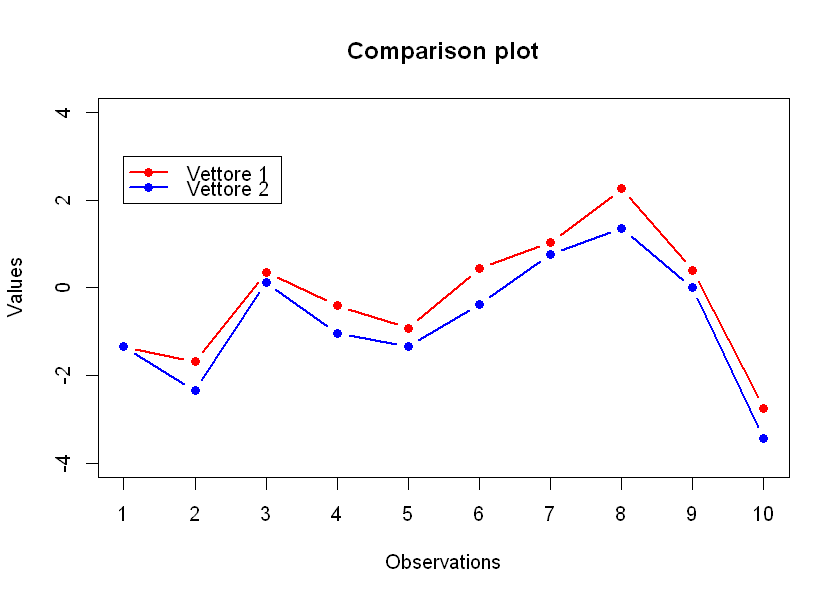

In [67]:
# Confronto le difficoltà iniziali e quelle stimate fissando il discriminante ad 1
validationWithDifference(diff, esDiffO)
validationWithPlot(diff, esDiffO)
paste("Coefficiente di correlazione lineare:",validationWithCor(diff, esDiffO))

Vettore 1,Vettore 2,Scostamento
-1.3331221,-1.142681309,0.19
-1.6786955,-1.980622905,0.30
0.3495336,0.112612424,0.24
-0.3960620,-0.884076331,0.49
-0.9156325,-1.142679118,0.23
0.4466848,-0.312705973,0.76
1.0409138,0.655973586,0.38
2.2605679,1.145602957,1.11
0.4016872,0.006899732,0.39
-2.7435525,-2.898903216,0.16


NULL

[1] "Coefficiente di correlazione lineare: 0.98076217973898"

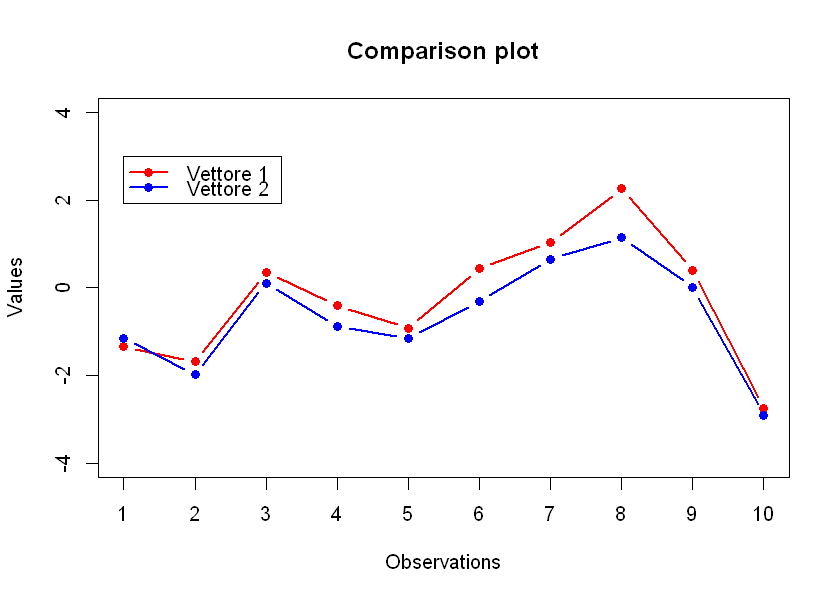

In [68]:
# Confronto le difficoltà iniziali e quelle stimate senza fissare il discriminante
validationWithDifference(diff, esDiffF)
validationWithPlot(diff, esDiffF)
paste("Coefficiente di correlazione lineare:",validationWithCor(diff, esDiffF))

NULL

[1] "Coefficiente di correlazione lineare: 0.999990813819062"

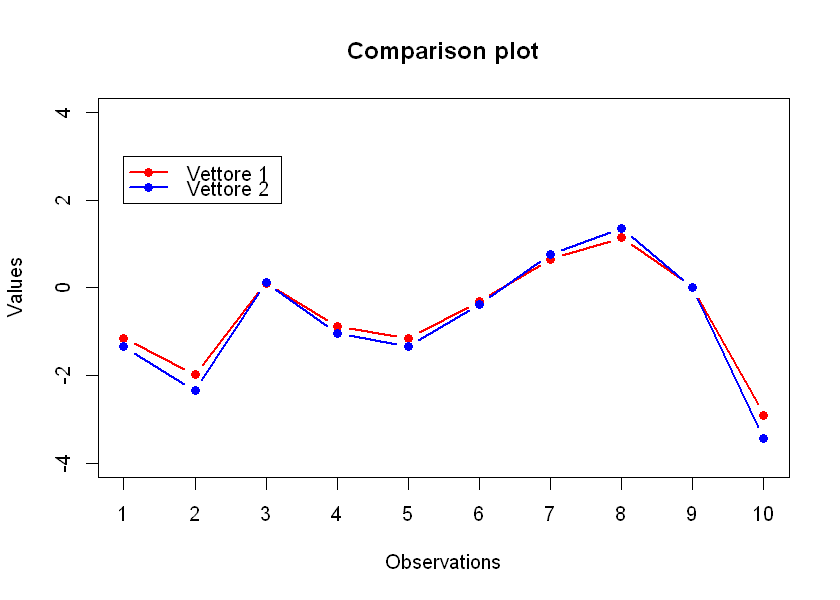

In [69]:
# Confronto le difficoltà stimate fissando il discriminante ad 1 con quelle stimate senza fissarlo
validationWithPlot(esDiffF, esDiffO)
paste("Coefficiente di correlazione lineare:",validationWithCor(esDiffF, esDiffO))

NULL

[1] "Coefficiente di correlazione lineare: 0.830675943093599"

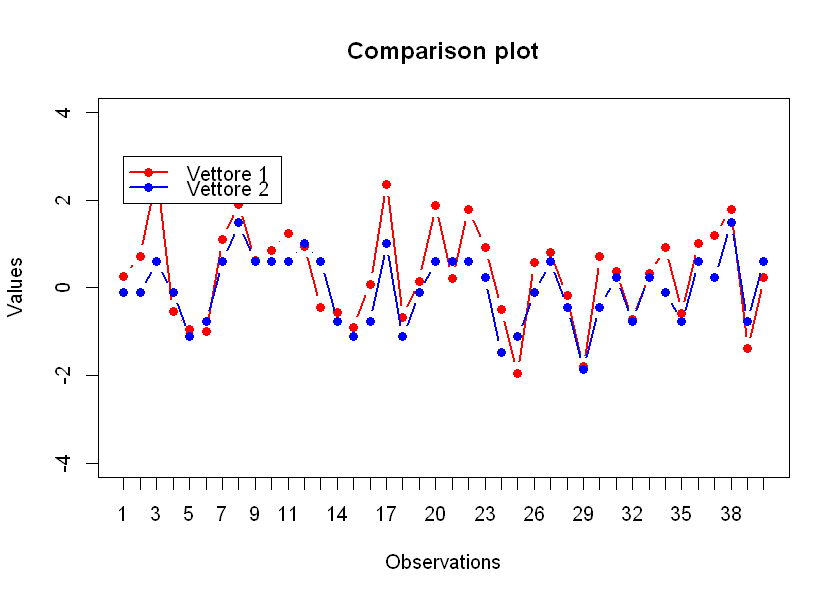

In [71]:
# Confronto le abilità iniziali e quelle stimate
validationWithPlot(abil, esAbil)
paste("Coefficiente di correlazione lineare:",validationWithCor(abil, esAbil))

In [240]:
# caricare i dati
source("data.R")

In [241]:
# elenco delle sessioni d’esame
sessions

[1] "170126"         "170216"         "170613"         "170711"        
 [5] "170914"         "laboratorio_01" "laboratorio_02" "laboratorio_03"
 [9] "laboratorio_04" "laboratorio_05" "laboratorio_06" "laboratorio_07"

In [242]:
# matrice che riporta, per ogni esercizio della sessione SESSION il numero dei testcase
cases_170126

,cases
01-censura_la_prima,5
02-studiare_stanca,5
03-piramide_di_numeri,5
04-disegna_serpente,4
05-stampante_configurabile,5
06-righello_orizzontale,6


In [243]:
# matrice 3d che riporta, per ogni studente ed esercizio, nelle varie dimensioni:
#    - se ha consegnato,
#    - se compila,
#    - quanti errori di esecuzione ci sono,
#    - quanti testcase che mostrano differenze col risultato atteso,
#    - quanti testcase funzionanno

In [244]:
# matrice esercizi x valutazioni i cui elementi rappresentano le informazioni per ogni esercizio dello studente 828035
results_170126["828035",,]

,uploaded,compiles,errors,diffs,oks
01-censura_la_prima,1,1,5,0,0
02-studiare_stanca,0,0,NA,NA,NA
03-piramide_di_numeri,0,0,NA,NA,NA
04-disegna_serpente,0,0,NA,NA,NA
05-stampante_configurabile,0,0,NA,NA,NA
06-righello_orizzontale,0,0,NA,NA,NA


In [245]:
# matrice studenti x valutazioni i cui elementi rappresentano le valutazioni degli studenti nell'esercizio 02-studiare_stanca
results_170126[,"02-studiare_stanca",]

,uploaded,compiles,errors,diffs,oks
828035,0,0,NA,NA,NA
840537,0,0,NA,NA,NA
858673,1,1,0,0,5
871599,0,0,NA,NA,NA
871806,1,1,0,2,3
872868,0,0,NA,NA,NA
873489,1,1,0,0,5
874225,0,0,NA,NA,NA
885299,1,1,0,4,1
885432,0,0,NA,NA,NA


In [247]:
# matrice studenti x esercizi i cui elementi rappresentano il numero di testcase superati con successo
results_170126[,,"oks"]

,01-censura_la_prima,02-studiare_stanca,03-piramide_di_numeri,04-disegna_serpente,05-stampante_configurabile,06-righello_orizzontale
828035,0,NA,NA,NA,NA,NA
840537,5,NA,NA,NA,NA,NA
858673,5,5,5,4,1,NA
871599,NA,NA,NA,NA,NA,NA
871806,5,3,5,4,NA,NA
872868,NA,NA,NA,NA,NA,NA
873489,5,5,NA,0,NA,NA
874225,0,NA,NA,NA,NA,NA
885299,5,1,NA,3,NA,NA
885432,5,NA,NA,NA,NA,NA


In [257]:
cases_laboratorio_01

,cases
01-conta_linee,3
02-conta_pokemon,2
03-conta_pokemon_diversi,2
04-salve_mondo,1
05-disegna_v,1
06-censura_la_seconda,4
07-incornicia_il_nome,4


In [258]:
results_laboratorio_01["891529",,]

,uploaded,compiles,errors,diffs,oks
01-conta_linee,0,0,NA,NA,NA
02-conta_pokemon,0,0,NA,NA,NA
03-conta_pokemon_diversi,0,0,NA,NA,NA
04-salve_mondo,0,0,NA,NA,NA
05-disegna_v,0,0,NA,NA,NA
06-censura_la_seconda,0,0,NA,NA,NA
07-incornicia_il_nome,0,0,NA,NA,NA


In [73]:
results_laboratorio_01[,"01-conta_linee",]

ERROR: Error in eval(expr, envir, enclos): object 'results_laboratorio_01' not found
